# General rundown
This notebook details the construction of the $C_\ell$ data vector for use in the main analysis, as well as the construction of the derivative vectors with respect to each cosmological parameter. Intitial forecasting is then done using the GetDist python library (big triangle plots)

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt

In [2]:
#Set up a dictionary of test parameters (this is used to check that the data vector is looking correct)
params_fiducial_test = {'Omega_c': 0.27,\
                           'Omega_b': 0.045,\
                           'h': 0.67,\
                           'A_s_norm': 2.1,\
                           'n_s': 0.96,\
                           'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
                           'w0': -0.9,\
                           'wa': 0,\
                           'mu_0': 0,\
                           'sigma_0': 0,\
                           'bcm_log10': 14.07918,\
                           'bcm_etab': 0.5,\
                           'bcm_ks': 55.0,\
                           'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15]}

In [3]:
def data_vector(params):
    '''This function takes a parameter argument which is a list of dictionaries used to vary one specific parameter,
    it then calculates the data vectors for each dict, allowing for the effects of varying each cosmological parameter
    on the data vectors form to be analysed'''
    
    
    #Set up the cosmology object with all parameters being used
    cosmo = ccl.Cosmology(Omega_c = params['Omega_c'],\
                          Omega_b = params['Omega_b'],\
                          h = params['h'],\
                          A_s = params['A_s_norm']*10**(-9),\
                          n_s = params['n_s'],\
                          w0 = params['w0'],\
                          wa = params['wa'],\
                          mu_0 = params['mu_0'],\
                          sigma_0 = params['sigma_0'],\
                          bcm_log10Mc = params['bcm_log10'],\
                          bcm_etab = params['bcm_etab'],\
                          bcm_ks = params['bcm_ks'],\
                          matter_power_spectrum = 'linear')
    
    #Load in lensing and clustering distributions and ell data
    dNdz_lens = np.loadtxt('dNdz_srcs_LSSTSRD_Y1.dat') 
    dNdz_clust = np.loadtxt('dNdz_clust_LSSTSRD_Y1.dat')
    ell = np.loadtxt('ell-values')
    
    #Construct tracer objects for clustering lensing and gg-lensing
    tracers_clust = []
    tracers_lens = []
    
    for i in range(5):
        tracers_clust.append(ccl.NumberCountsTracer(cosmo,\
                                                    has_rsd=False,\
                                                    dndz=(dNdz_clust[:,0],\
                                                    dNdz_clust[:,i+1]),\
                                                    bias=(dNdz_clust[:,0], params['bias'][i]*np.ones(2000))))
    
        tracers_lens.append(ccl.WeakLensingTracer(cosmo,\
                                                  dndz=(dNdz_lens[:,0], dNdz_lens[:,i+1]),\
                                                  ia_bias=(dNdz_lens[:,0], params['ia_bias'][i]*np.ones(2000))))
    
    #Now that the tracers are constructed, calculate C_l's for clustering, gg-lensing and shear
    cls_clus = []
    cls_gg = []
    cls_gg_clean = []
    #this concerns the specific redshift bins that are to be eliminated from the gg-lensing cl data
    gglensing = [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    cls_lens = []
    
    #append calculated cl values to the cl lists for each respective effect 
    for i in range(len(tracers_clust)):
        
        cls_clus.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_clust[i], ell))
        
        for j in range(len(tracers_clust)):
            
            cls_gg.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_lens[j], ell))
            
            if i >= j:
                cls_lens.append(ccl.angular_cl(cosmo,tracers_lens[i], tracers_lens[j], ell))
                
    for n in range(len(gglensing)):
        if gglensing[n] == 1:
            cls_gg_clean.append(cls_gg[n])

    #Clean up the data vectors shapes and combine them all
    cls_lens = np.append(cls_lens, cls_gg_clean)
    cls_combined = np.append(cls_lens, cls_clus)
    
    return cls_combined

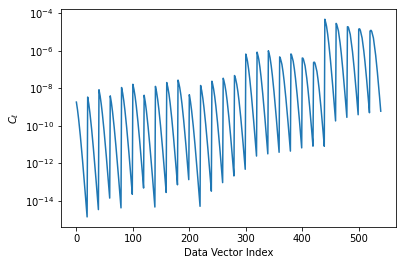

In [4]:
#Check that the data vector is looking as it should be (in comparison to the LSST one) - the order that must be used for
#this analysis is shear-gglensing-clustering as this matches the order for the covariance matrix used in the later fisher calculation

data_vector_fiducial = data_vector(params_fiducial_test)

plt.plot(data_vector_fiducial)
plt.yscale('log')
plt.ylabel('$C_\ell$')
plt.xlabel('Data Vector Index')
plt.show()

### Finite difference method to calculate the numerical derivative data vectors (should be 540 long)

In [5]:
def numerical_deriv(param,h):
    '''This function takes a parameter "param" and a value for h to calculate the numerical derivative with respect to param of
    each index of the c_ell value data vector. Note - h is as a percentage of the fiducial value of the parameter "param".
    This is done through the use of the 5 point finite difference method. This function only takes inputs of a string for 
    "param" and a positive value of h.'''
    if type(param) != str:
        print('Please input a parameter name as a string')

    if h <= 0:
        print('Please input a positive, non-zero value for h')
        
    #Define the fiducial parameters for the model that will be varied by h%
    #Since the values for mu0 sig0 and wa are 0 initially, set these to some small values to allow for the
    #derivative function to work properly 
    if param == 'mu_0' or param == 'sigma_0' or param == 'wa':
        params_fiducial = {'Omega_c': 0.27,\
                            'Omega_b': 0.045,\
                            'h': 0.67,\
                            'A_s_norm': 2.1,\
                            'n_s': 0.96,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': -0.9,\
                            'wa': 0.1,\
                            'mu_0': 0.1,\
                            'sigma_0': 0.1,\
                            'bcm_log10': 14.07918,\
                            'bcm_etab': 0.5,\
                            'bcm_ks': 55.0,\
                            'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15]}
    else:
        params_fiducial = {'Omega_c': 0.27,\
                            'Omega_b': 0.045,\
                            'h': 0.67,\
                            'A_s_norm': 2.1,\
                            'n_s': 0.96,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': -0.9,\
                            'wa': 0.0,\
                            'mu_0': 0.0,\
                            'sigma_0': 0.0,\
                            'bcm_log10': 14.07918,\
                            'bcm_etab': 0.5,\
                            'bcm_ks': 55.0,\
                            'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15]}

    #Create a dictionary list that varies the specified parameter by -2h,-h,h,2h
    
    params_pos2h  = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0,\
                        'bcm_log10': 14.07918,\
                        'bcm_etab': 0.5,\
                        'bcm_ks': 55.0,\
                        'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15]}
    
    params_posh = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0,\
                        'bcm_log10': 14.07918,\
                        'bcm_etab': 0.5,\
                        'bcm_ks': 55.0,\
                        'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15]}
    
    params_negh = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0,\
                        'bcm_log10': 14.07918,\
                        'bcm_etab': 0.5,\
                        'bcm_ks': 55.0,\
                        'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15]}
    
    params_neg2h = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0,\
                        'bcm_log10': 14.07918,\
                        'bcm_etab': 0.5,\
                        'bcm_ks': 55.0,\
                        'ia_bias': [0.15, 0.15, 0.15, 0.15, 0.15]}
    if param == 'bias_1':
        params_pos2h['bias'][0] += 2*h*params_fiducial['bias'][0]
        
        params_posh['bias'][0] += h*params_fiducial['bias'][0]
        
        params_negh['bias'][0] -= h*params_fiducial['bias'][0]
        
        params_neg2h['bias'][0] -= 2*h*params_fiducial['bias'][0]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['bias'][0]))
        
    elif param == 'bias_2':
        params_pos2h['bias'][1] += 2*h*params_fiducial['bias'][1]
        
        params_posh['bias'][1] += h*params_fiducial['bias'][1]
        
        params_negh['bias'][1] -= h*params_fiducial['bias'][1]
        
        params_neg2h['bias'][1] -= 2*h*params_fiducial['bias'][1]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['bias'][1]))
        
    elif param == 'bias_3':
        params_pos2h['bias'][2] += 2*h*params_fiducial['bias'][2]
        
        params_posh['bias'][2] += h*params_fiducial['bias'][2]
        
        params_negh['bias'][2] -= h*params_fiducial['bias'][2]
        
        params_neg2h['bias'][2] -= 2*h*params_fiducial['bias'][2]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['bias'][2]))
        
    elif param == 'bias_4':
        params_pos2h['bias'][3] += 2*h*params_fiducial['bias'][3]
        
        params_posh['bias'][3] += h*params_fiducial['bias'][3]
        
        params_negh['bias'][3] -= h*params_fiducial['bias'][3]
        
        params_neg2h['bias'][3] -= 2*h*params_fiducial['bias'][3]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['bias'][3]))
        
    elif param == 'bias_5':
        params_pos2h['bias'][4] += 2*h*params_fiducial['bias'][4]
        
        params_posh['bias'][4] += h*params_fiducial['bias'][4]
        
        params_negh['bias'][4] -= h*params_fiducial['bias'][4]
        
        params_neg2h['bias'][4] -= 2*h*params_fiducial['bias'][4]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['bias'][4]))
        
    elif param == 'ia_bias_1':
        params_pos2h['ia_bias'][0] += 2*h*params_fiducial['ia_bias'][0]
        
        params_posh['ia_bias'][0] += h*params_fiducial['ia_bias'][0]
        
        params_negh['ia_bias'][0] -= h*params_fiducial['ia_bias'][0]
        
        params_neg2h['ia_bias'][0] -= 2*h*params_fiducial['ia_bias'][0]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['ia_bias'][0]))
        
    elif param == 'ia_bias_2':
        params_pos2h['ia_bias'][1] += 2*h*params_fiducial['ia_bias'][1]
        
        params_posh['ia_bias'][1] += h*params_fiducial['ia_bias'][1]
        
        params_negh['ia_bias'][1] -= h*params_fiducial['ia_bias'][1]
        
        params_neg2h['ia_bias'][1] -= 2*h*params_fiducial['ia_bias'][1]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['ia_bias'][1]))
        
    elif param == 'ia_bias_3':
        params_pos2h['ia_bias'][2] += 2*h*params_fiducial['ia_bias'][2]
        
        params_posh['ia_bias'][2] += h*params_fiducial['ia_bias'][2]
        
        params_negh['ia_bias'][2] -= h*params_fiducial['ia_bias'][2]
        
        params_neg2h['ia_bias'][2] -= 2*h*params_fiducial['ia_bias'][2]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['ia_bias'][2]))
        
    elif param == 'ia_bias_4':
        params_pos2h['ia_bias'][3] += 2*h*params_fiducial['ia_bias'][3]
        
        params_posh['ia_bias'][3] += h*params_fiducial['ia_bias'][3]
        
        params_negh['ia_bias'][3] -= h*params_fiducial['ia_bias'][3]
        
        params_neg2h['ia_bias'][3] -= 2*h*params_fiducial['ia_bias'][3]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['ia_bias'][3]))
        
    elif param == 'ia_bias_5':
        params_pos2h['ia_bias'][4] += 2*h*params_fiducial['ia_bias'][4]
        
        params_posh['ia_bias'][4] += h*params_fiducial['ia_bias'][4]
        
        params_negh['ia_bias'][4] -= h*params_fiducial['ia_bias'][4]
        
        params_neg2h['ia_bias'][4] -= 2*h*params_fiducial['ia_bias'][4]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['ia_bias'][4]))
    
    
    else:
        params_pos2h[f"{param}"] += 2*h*params_fiducial[f"{param}"]
    
        params_posh[f"{param}"] += h*params_fiducial[f"{param}"]
    
        params_negh[f"{param}"] -= h*params_fiducial[f"{param}"]
    
        params_neg2h[f"{param}"] -= 2*h*params_fiducial[f"{param}"]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                                  + 8*data_vector(params_posh)\
                                  - 8*data_vector(params_negh)\
                                  + data_vector(params_neg2h))/(12*h*params_fiducial[f"{param}"]))

    return parameter_deriv_vector

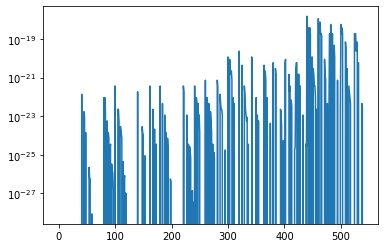

In [6]:
ia_bias_1_deriv = numerical_deriv('ia_bias_1', 0.01)

plt.plot(ia_bias_1_deriv)

plt.yscale('log')

plt.show()

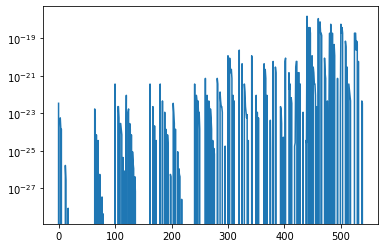

In [7]:
ia_bias_2_deriv = numerical_deriv('ia_bias_2', 0.01)

plt.plot(ia_bias_2_deriv)
plt.yscale('log')

plt.show()

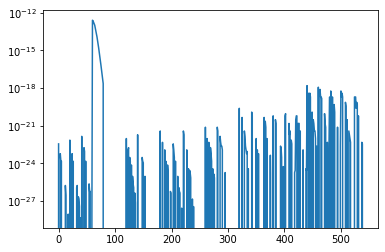

In [8]:
ia_bias_3_deriv = numerical_deriv('ia_bias_3', 0.01)

plt.plot(ia_bias_3_deriv)

plt.yscale('log')
plt.show()

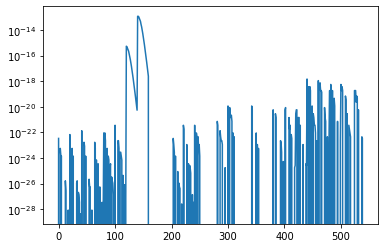

In [9]:
ia_bias_4_deriv = numerical_deriv('ia_bias_4', 0.01)

plt.plot(ia_bias_4_deriv)

plt.yscale('log')
plt.show()

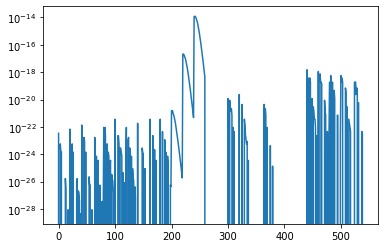

In [10]:
ia_bias_5_deriv = numerical_deriv('ia_bias_5', 0.01)

plt.plot(ia_bias_5_deriv)

plt.yscale('log')
plt.show()

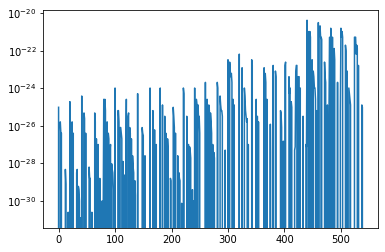

In [11]:
bcm_ks_deriv = numerical_deriv('bcm_ks', 0.01)

plt.plot(bcm_ks_deriv)
plt.yscale('log')

plt.show()

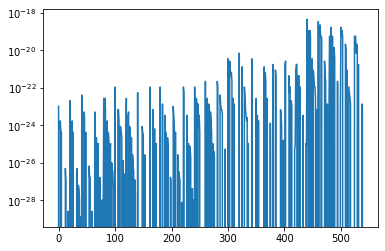

In [12]:
bcm_etab_deriv = numerical_deriv('bcm_etab', 0.01)

plt.plot(bcm_etab_deriv)
plt.yscale('log')
plt.show()

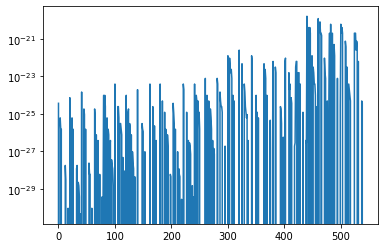

In [13]:
bcm_log10_deriv = numerical_deriv('bcm_log10', 0.01)

plt.plot(bcm_log10_deriv)
plt.yscale('log')
plt.show()

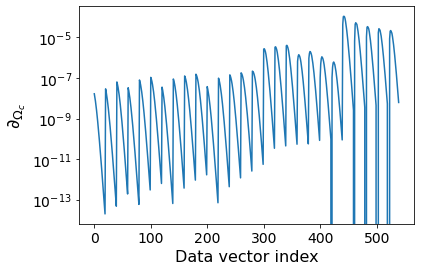

In [14]:
Omega_c_deriv = numerical_deriv('Omega_c', 0.01)

plt.plot(Omega_c_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{\Omega_c}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

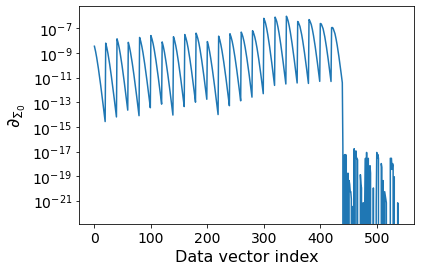

In [15]:
sig_0_deriv = numerical_deriv('sigma_0', 0.001)

plt.plot(sig_0_deriv)
plt.plot()
plt.yscale('log')
plt.ylabel('$\partial_{\Sigma_0}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

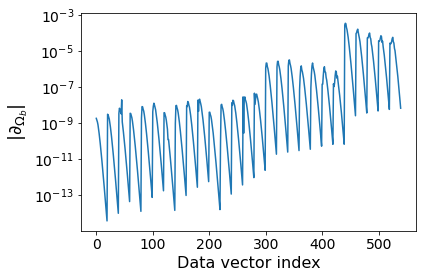

In [16]:
Omega_b_deriv = numerical_deriv('Omega_b', 0.001)

plt.plot(np.abs(Omega_b_deriv))
plt.yscale('log')
plt.ylabel('$|\partial_{\Omega_b}|$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

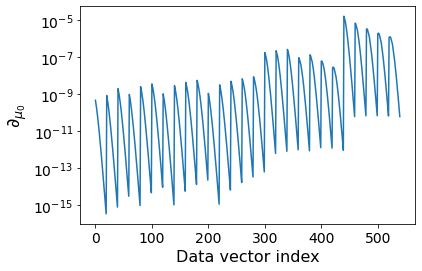

In [17]:
mu_0_deriv= numerical_deriv('mu_0', 0.001)

plt.plot(mu_0_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{\mu_0}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

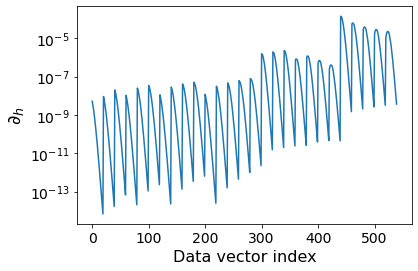

In [18]:
h_deriv = numerical_deriv('h', 0.001)

plt.plot(h_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{h}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

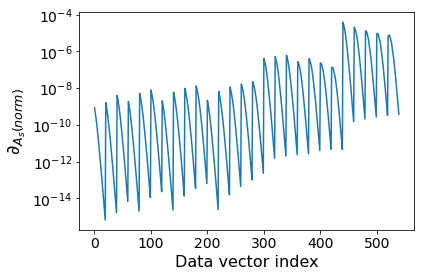

In [19]:
A_s_norm_deriv = numerical_deriv('A_s_norm', 0.001 )

plt.plot(A_s_norm_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{A_s(norm)}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

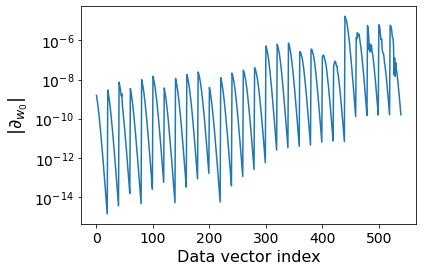

In [20]:
w0_deriv = numerical_deriv('w0', 0.001)

plt.plot(np.abs(w0_deriv))
plt.yscale('log')
plt.ylabel('$|\partial_{w_0}|$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

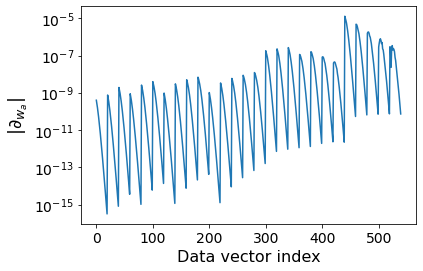

In [21]:
wa_deriv = numerical_deriv('wa', 0.001)

plt.plot(np.abs(wa_deriv))
plt.yscale('log')
plt.ylabel('$|\partial_{w_a}|$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

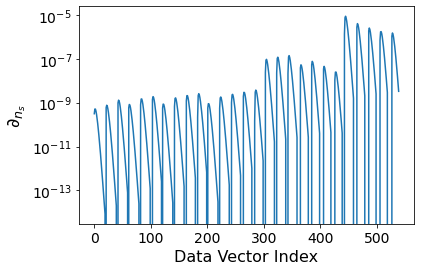

In [22]:
n_s_deriv = numerical_deriv('n_s', 0.001)

plt.plot(n_s_deriv)
plt.xlabel('Data Vector Index', fontsize = 16)
plt.ylabel('$\partial_{n_s}$', fontsize = 18)
plt.yscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

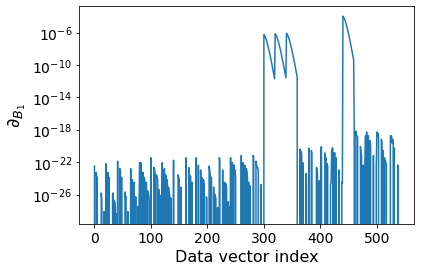

In [23]:
bias_1_deriv = numerical_deriv('bias_1', 0.001)

plt.plot(bias_1_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_1}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

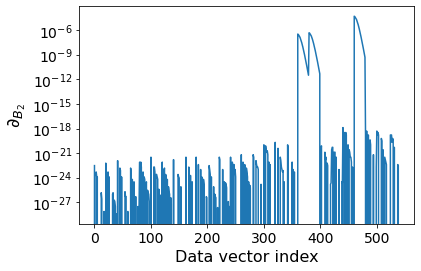

In [24]:
bias_2_deriv = numerical_deriv('bias_2', 0.001)

plt.plot(bias_2_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_2}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

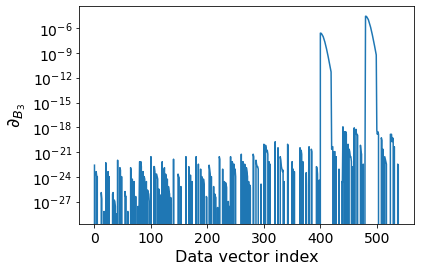

In [25]:
bias_3_deriv = numerical_deriv('bias_3', 0.001)

plt.plot(bias_3_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_3}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

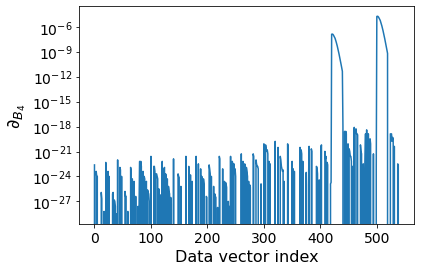

In [26]:
bias_4_deriv = numerical_deriv('bias_4', 0.001)

plt.plot(bias_4_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_4}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

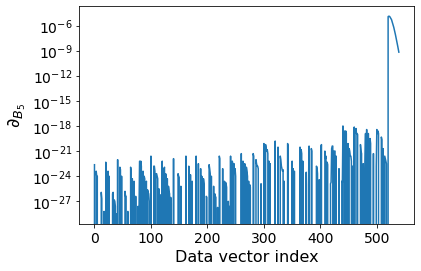

In [27]:
bias_5_deriv = numerical_deriv('bias_5', 0.001)

plt.plot(bias_5_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_5}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

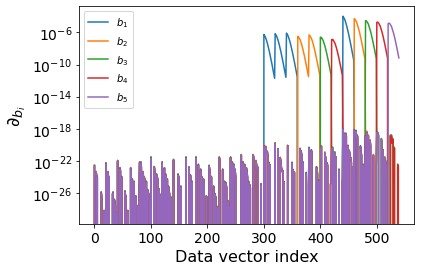

In [28]:
#This plot is solely for the purpose of checking that all galaxy bias derivatives look right together

plt.plot(bias_1_deriv, label = '$b_1$')
plt.plot(bias_2_deriv, label = '$b_2$')
plt.plot(bias_3_deriv, label = '$b_3$')
plt.plot(bias_4_deriv, label = '$b_4$')
plt.plot(bias_5_deriv, label = '$b_5$')

plt.yscale('log')
plt.ylabel('$\partial_{b_i}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()

plt.show()

# Start on Fisher matrix calculation
### Load in covariance matrix, multiply deriv by inv cov by deriv

In [29]:
inv_cov = np.loadtxt('inv_cov_matrix') #read in the saved inverse covariance matrix used for fisher matrix calculation
#mask = np.loadtxt('scale_mask') #read in the scale cutting mask
#print(np.shape(mask))
print(np.shape(inv_cov))
print(inv_cov)

(540, 540)
[[ 5.93063017e+18 -2.97754813e+16 -4.66205760e+16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.97754813e+16  1.27555122e+19 -7.41638895e+16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.66205760e+16 -7.41638895e+16  2.70979734e+19 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [30]:
#Construct a list that we can iterate through that contains our derivative data vectors
derivatives = [Omega_c_deriv,\
               Omega_b_deriv,\
               h_deriv,\
               A_s_norm_deriv,\
               n_s_deriv,\
               bias_1_deriv,\
               bias_2_deriv,\
               bias_3_deriv,\
               bias_4_deriv,\
               bias_5_deriv,\
               sig_0_deriv,\
               mu_0_deriv,\
               w0_deriv,\
               wa_deriv,\
               ia_bias_1_deriv,\
               ia_bias_2_deriv,\
               ia_bias_3_deriv,\
               ia_bias_4_deriv,\
               ia_bias_5_deriv]

In [31]:
#initialise a numpy array for our fisher matrices for h = 10^-2 and the LSST fisher matrix which is used for comparison
#fisher = np.zeros(shape = (14,14))
deriv_size = len(derivatives) #should be 19
fisher = np.zeros([deriv_size, deriv_size])

fisher_LSST_Y1 = np.array([[4.321685e+05, 2.754616e+05, 5.992140e+04, -1.992358e+04, -4.473057e+03, -2.164983e+05, 5.264462e+04],
[2.754616e+05, 2.082198e+05, 2.691262e+04, -1.379929e+04, -3.407022e+03, -7.745383e+04, 1.946493e+04],
[5.992140e+04, 2.691262e+04, 2.414847e+04, -6.937346e+02, -1.056892e+02, -6.207807e+04, 1.576508e+04],
[-1.992358e+04, -1.379929e+04, -6.937346e+02, 1.395740e+03, 3.162361e+02, 4.976017e+03, -1.248729e+03],
[-4.473057e+03, -3.407022e+03, -1.056892e+02, 3.162361e+02, 8.081758e+01, 9.051103e+02, -2.218407e+02],
[-2.164983e+05, -7.745383e+04, -6.207807e+04, 4.976017e+03, 9.051103e+02, 3.877220e+05, -6.499201e+04],
[5.264462e+04, 1.946493e+04, 1.576508e+04, -1.248729e+03, -2.218407e+02, -6.499201e+04, 1.565908e+04]])

In [50]:
#apply mask to derivative vector (cuts down certain scales)
for i in range(len(derivatives)):
    for j in range(540):
        derivatives[i][j] = derivatives[i][j]*mask[j]

NameError: name 'mask' is not defined

In [51]:
#loop to construct the fisher matrix, looping over the parameter derivatives

for i in range(len(derivatives)):
    for j in range(len(derivatives)):
        fisher[i][j] = np.matmul(derivatives[i], (np.matmul(inv_cov, derivatives[j])))

In [52]:
print(np.shape(fisher))
print(np.shape(fisher_LSST_Y1))

(19, 19)
(7, 7)


In [53]:
#eliminate rows and columns associated with modified gravity parameters in the fisher matrix 
#(treating the two as constant essentially) store in a new variable

fisher_no_mg = np.delete(fisher, 10, 0)
fisher_no_mg = np.delete(fisher_no_mg, 10, 1)
fisher_no_mg = np.delete(fisher_no_mg, 10, 0)
fisher_no_mg = np.delete(fisher_no_mg, 10, 1)


print(np.shape(fisher_no_mg))

(17, 17)


In [54]:
#1 sigma standard deviations between for each parameter in the original fisher matrix
sig_1_dev = []
for i in range(14):
    sig_1_dev.append((np.sqrt(fisher[i][i]))**(-1))
    
print(sig_1_dev)

#This is just a check to see that the sig_1 deviations for each parameter are looking sensible

[0.00041789200978009465, 0.0004276298823505096, 0.000806042674097648, 0.005598709426020286, 0.0027086932778064943, 0.009688727496699853, 0.007603189851945894, 0.006533095276035362, 0.007020818879051252, 0.00608333552391414, 0.0030411113573452406, 0.018878007385062307, 0.0040478782363851835, 0.014112662298711177]


In [55]:
#parameter covariance matrix is inverse of the fisher matrix so calculate parameter covariances for each fisher
param_cov = np.linalg.inv(fisher)

param_cov_LSST_Y1 = np.linalg.inv(fisher_LSST_Y1)

param_cov_no_mg = np.linalg.inv(fisher_no_mg)

In [60]:
#check that the standard deviations are all positive in the regular parameter covariance matrix
pos_or_neg = []

for i in range(19):
    if param_cov[i][i] < 0:
        pos_or_neg.append('neg')
    else:
        pos_or_neg.append('pos')
        
print(pos_or_neg)

['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos']


In [61]:
print(np.linalg.eig(param_cov)[0]) #ensure that all eigenvalues of the parameter covariance matrix are positive

[1.80089544e+01 8.52744195e-01 1.86417570e-01 5.04868288e-02
 1.52091324e-02 1.17271117e-02 3.59879082e-03 2.56581296e-03
 2.03525543e-03 9.97781242e-04 3.25479950e-04 8.81790508e-08
 5.92453291e-07 8.70647128e-05 1.87703601e-05 3.76449185e-05
 4.34046851e-05 6.02084424e-05 5.47890988e-05]


In [62]:
#we use the getdist package to plot the confidence interval contours that arise from the fisher forecast

from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist

In [66]:
#params_fiducial = {'Omega_c': 0.27,\
 #                          'Omega_b': 0.045,\
  #                         'h': 0.67,\
   #                        'A_s_norm': 2.1,\
    #                       'n_s': 0.96,\
     #                      'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
      #                     'w0': -0.9,\
        #                   'mu_0': 0,\
       #                    'sigma_0': 0 }

param_mean = [0.27, 0.045, 0.67, 2.1, 0.96, 1.562362, 1.732963, 1.913252, 2.100644, 2.293210, 0, 0, -0.9, 0.0, 0.15, 0.15, 0.15, 0.15, 0.15]


param_names = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s', 'B1', 'B2', 'B3', 'B4', 'B5,' 'Sigma_0', 'mu_0', 'w0', 'wa', 'B1IA', 'B2IA', 'B3IA', 'B4IA', 'B5IA']

labels = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'B^{1}', r'B^{2}', r'B^{3}', r'B^{4}', r'B^{5}', r'\Sigma_{0}', r'\mu_{0}', r'w_{0}', r'w_{a}', r'B^{1}_{IA}', r'B^{2}_{IA}', r'B^{3}_{IA}', r'B^{4}_{IA}', r'B^{5}_{IA}']


gauss = GaussianND(param_mean, param_cov, labels = labels, names = param_names)

In [67]:
g = plots.get_subplot_plotter() #subplotter instance for chainconsumer (used for triangle plots)

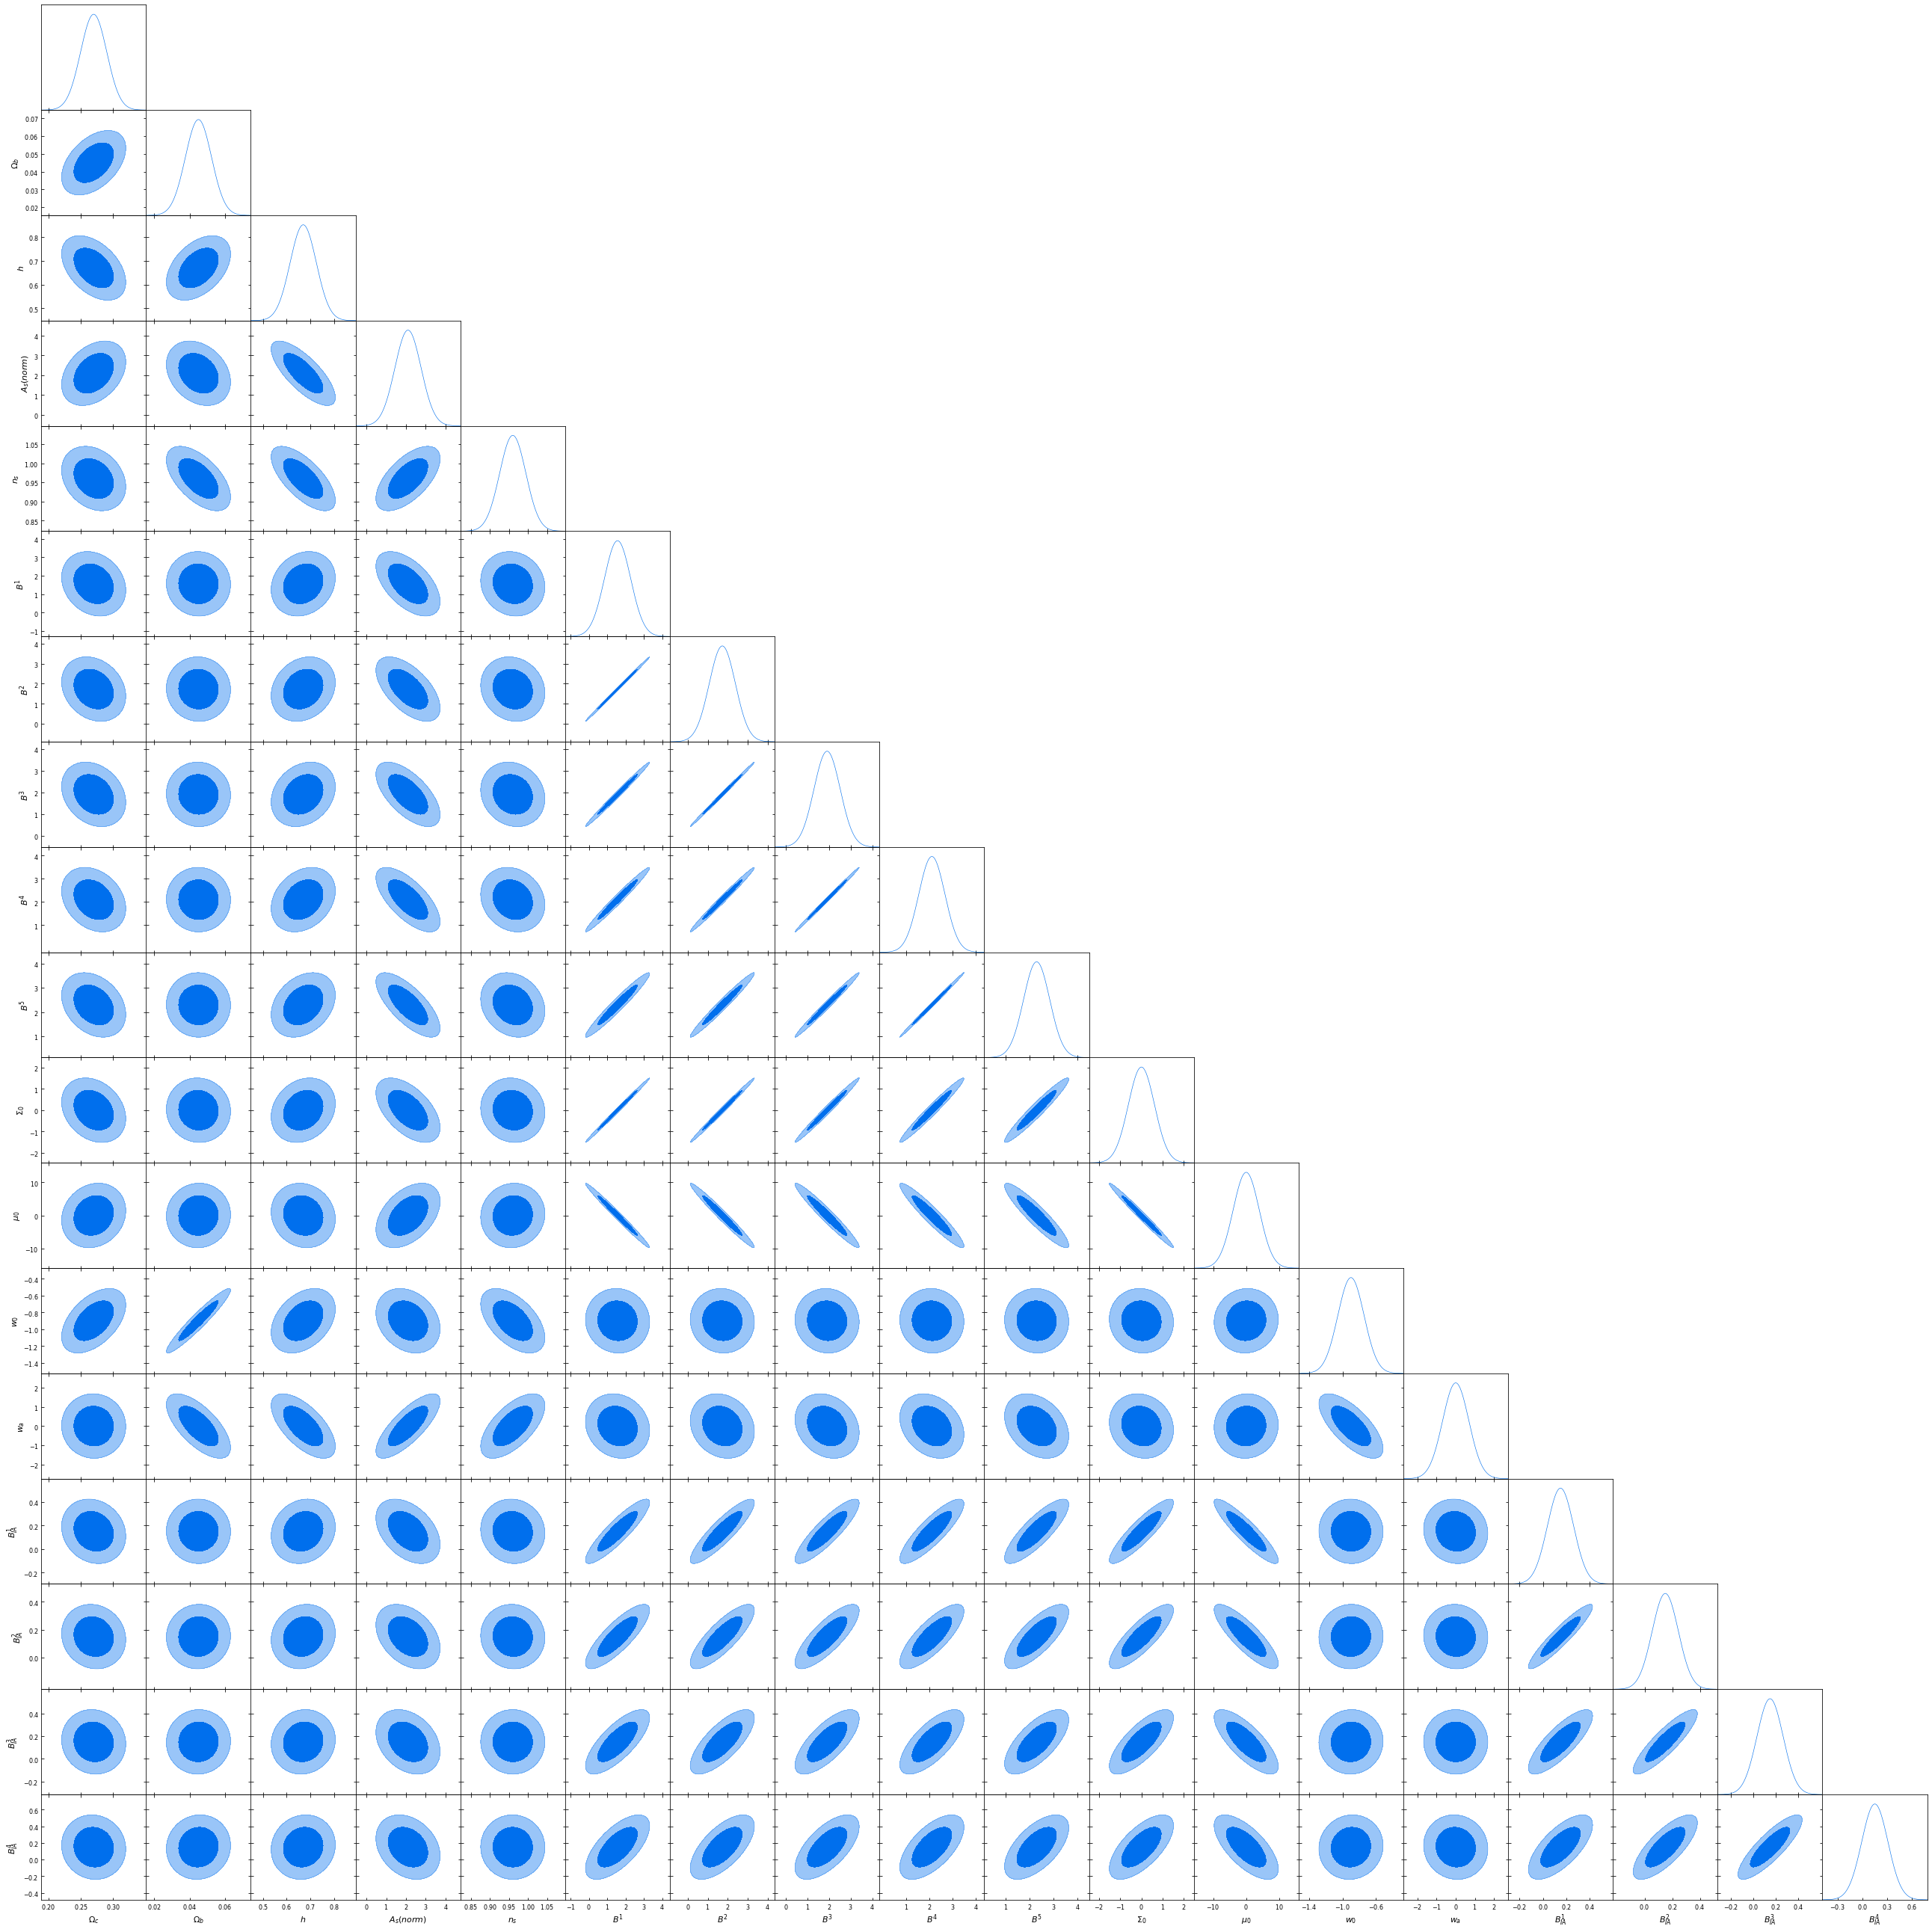

In [68]:
g = plots.get_subplot_plotter() #create a traingle plot for the full fisher forecast w/ all params
g.triangle_plot(gauss, filled = True)

In [36]:
#deleting galaxy bias parameters from plots by removing from the parameter covariance matrix

param_cov_cleaned_1 = np.delete(param_cov, 5, 0)
param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 1)

param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 0)
param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 1)

param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 0)
param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 1)

param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 0)
param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 1)

param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 0)
param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 1)

print(np.shape(param_cov_cleaned_1))

(9, 9)


In [37]:
param_mean_cleaned = [0.27, 0.045, 0.67, 2.1, 0.96, 0, 0, -0.9, 0.0]


param_names_cleaned = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s','Sigma_0', 'mu_0', 'w0', 'wa']

labels_cleaned = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'\Sigma_{0}', r'\mu_{0}', r'w_{0}', r'w_{a}']

gauss_cleaned_1 = GaussianND(param_mean_cleaned, param_cov_cleaned_1, labels = labels_cleaned, names = param_names_cleaned)

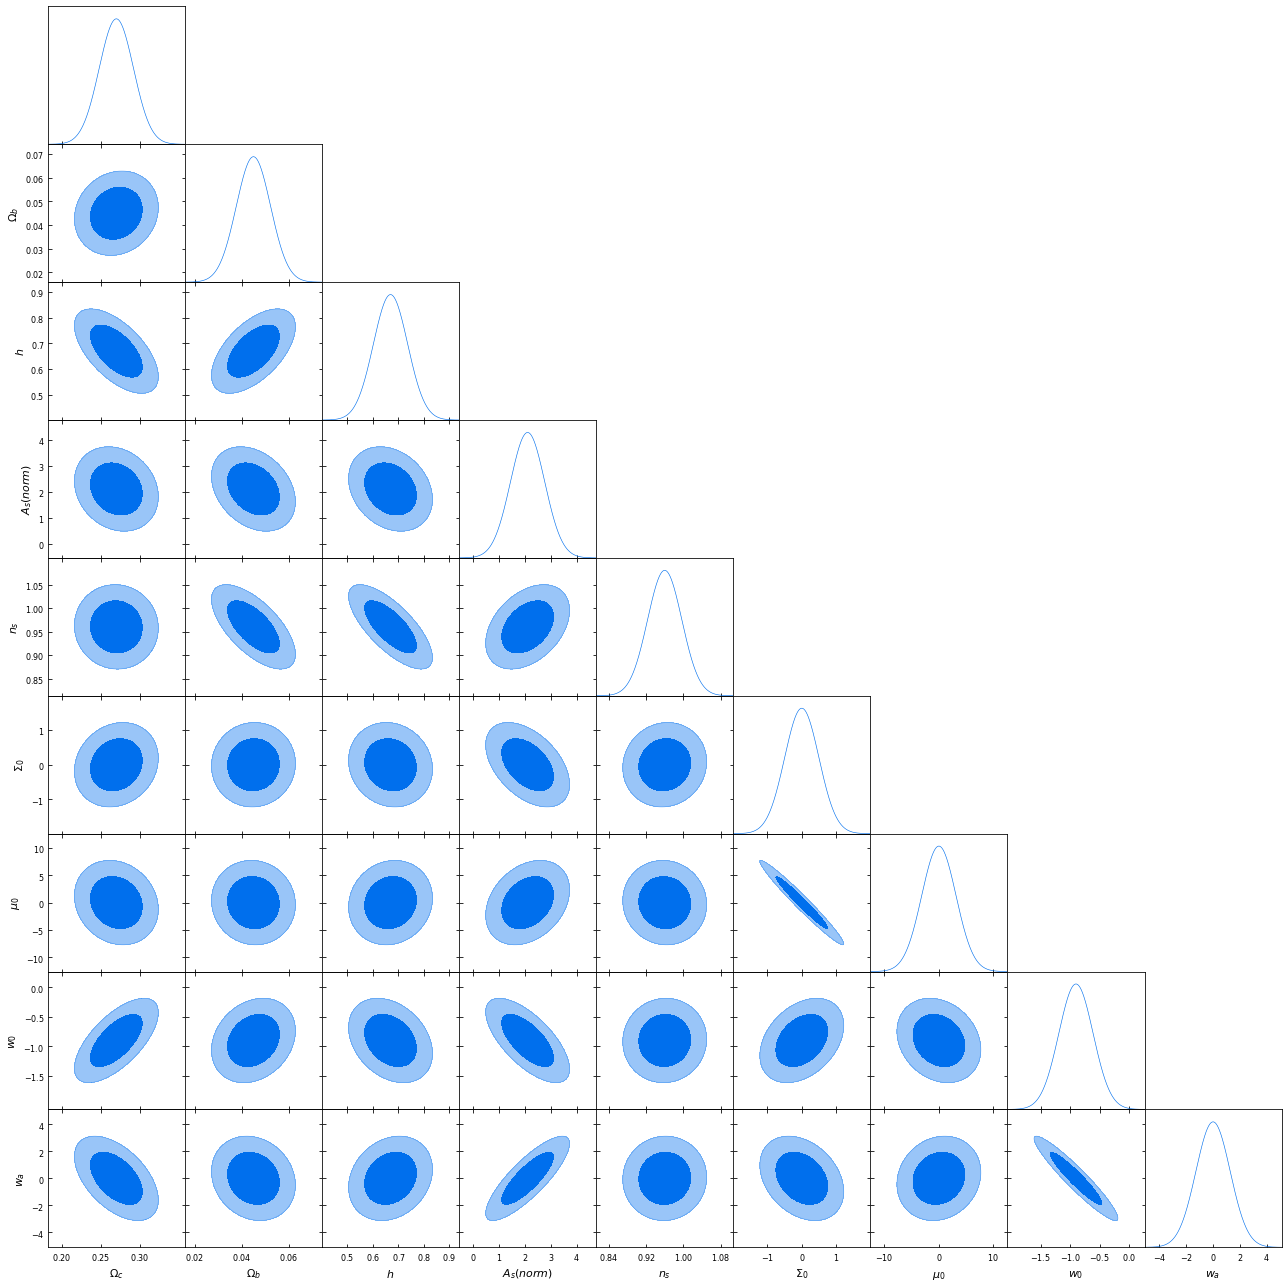

In [38]:
g.triangle_plot(gauss_cleaned_1, filled = True) #reduced parameter set (no galaxy bias)

In [39]:
param_names_LSST = ['Omega_m', 'sigma8', 'n_s', 'w0', 'wa', 'omega_b', 'h0']
labels_LSST = [r'\Omega_{m}', r'\sigma_{8}', r'n_{s}', r'w_{0}', r'w_{a}', r'\Omega_{b}', r'h_{0}']
mean_LSST = [0.27, 0.83, 0.96, -0.9, 0.0, 0.0450, 0.67]

gauss_LSST = GaussianND(mean_LSST ,param_cov_LSST_Y1, labels = labels_LSST, names = param_names_LSST)


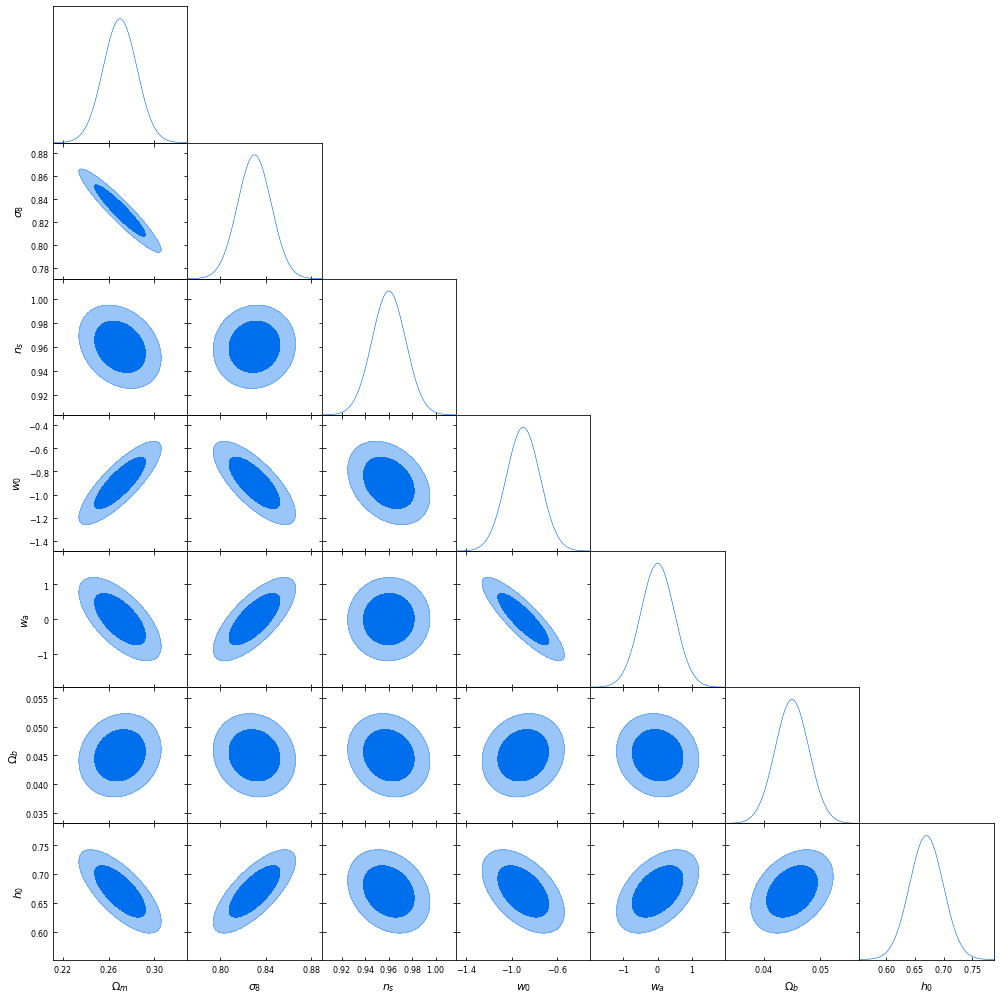

In [40]:
g.triangle_plot(gauss_LSST, filled = True) #LSST plot from their Fisher matrix

In [41]:
#params_fiducial = {'Omega_c': 0.27,\
 #                          'Omega_b': 0.045,\
  #                         'h': 0.67,\
   #                        'A_s_norm': 2.1,\
    #                       'n_s': 0.96,\
     #                      'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
      #                     'w0': -0.9,\
        #                   'mu_0': 0,\
       #                    'sigma_0': 0 }

param_mean_no_mg = [0.27, 0.045, 0.67, 2.1, 0.96, 1.562362, 1.732963, 1.913252, 2.100644, 2.293210, -0.9, 0.0]


param_names_no_mg = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s', 'B1', 'B2', 'B3', 'B4', 'B5', 'w0', 'wa']

labels_no_mg = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'B^{1}', r'B^{2}', r'B^{3}', r'B^{4}', r'B^{5}', r'w_{0}', r'w_{a}']


gauss_no_mg=GaussianND(param_mean_no_mg, param_cov_no_mg, labels = labels_no_mg, names = param_names_no_mg)

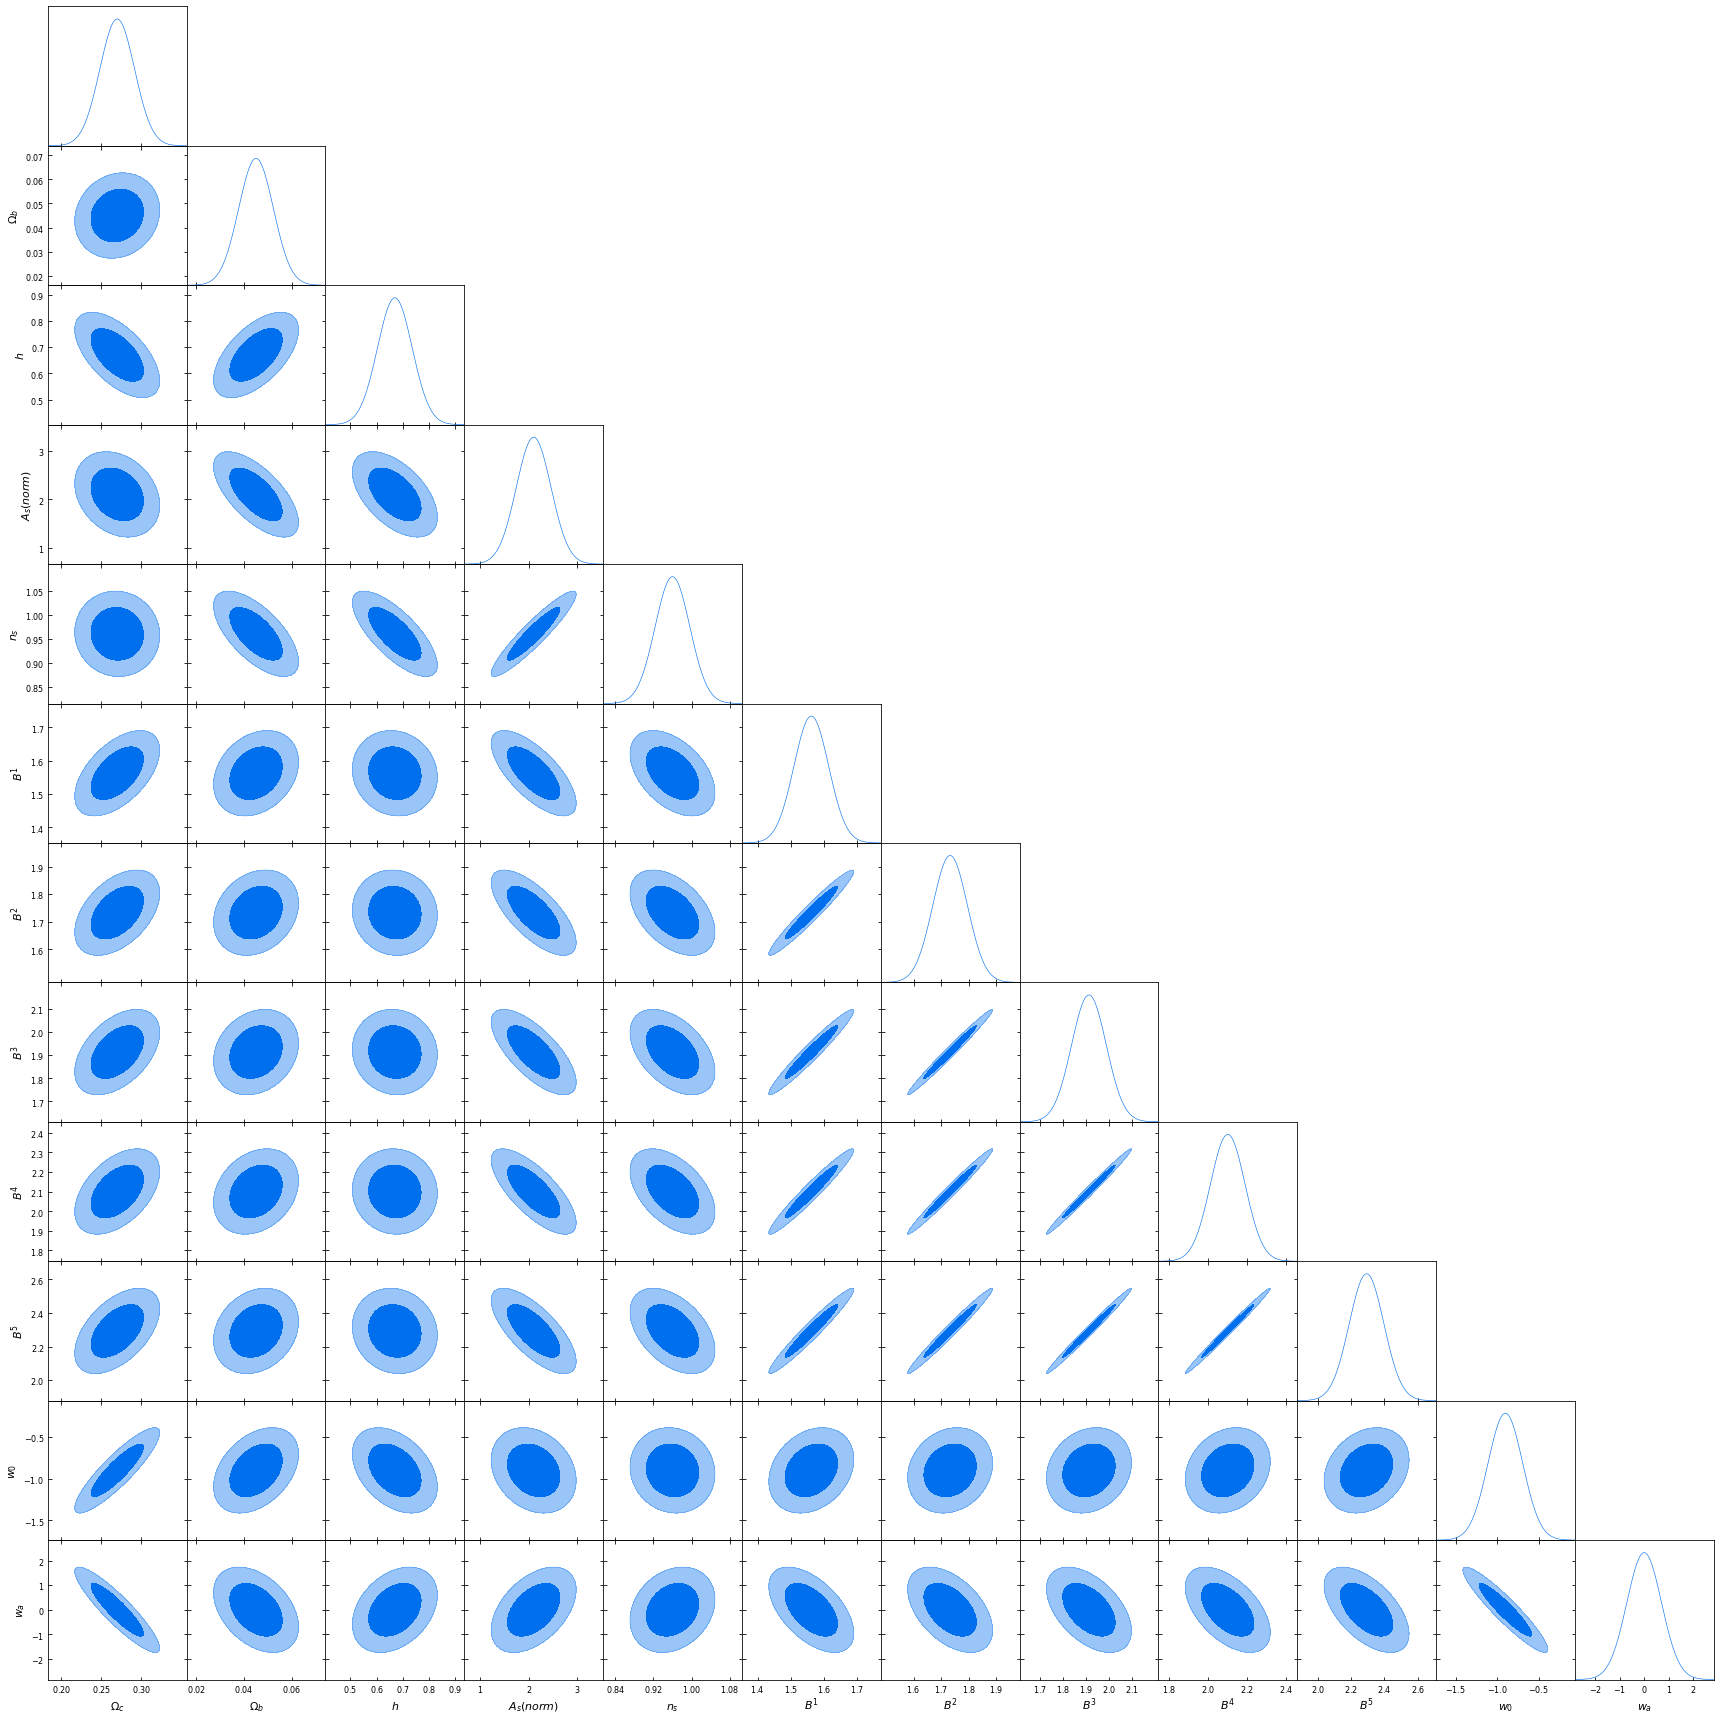

In [42]:
g.triangle_plot(gauss_no_mg, filled = True) #plot with no modified gravity parameters included 

In [43]:
#now clean up the no mg forecast by getting rid of bias constraints
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

print(np.shape(param_cov_no_mg_no_bias))

(7, 7)


In [44]:
param_mean_no_mg_no_bias = [0.27, 0.045, 0.67, 2.1, 0.96, -0.9, 0.0]


param_names_no_mg_no_bias = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s', 'w0', 'wa']

labels_no_mg_no_bias = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'w_{0}', r'w_{a}']


gauss_no_mg_no_bias = GaussianND(param_mean_no_mg_no_bias,\
                                 param_cov_no_mg_no_bias,\
                                 labels = labels_no_mg_no_bias,\
                                 names = param_names_no_mg_no_bias)

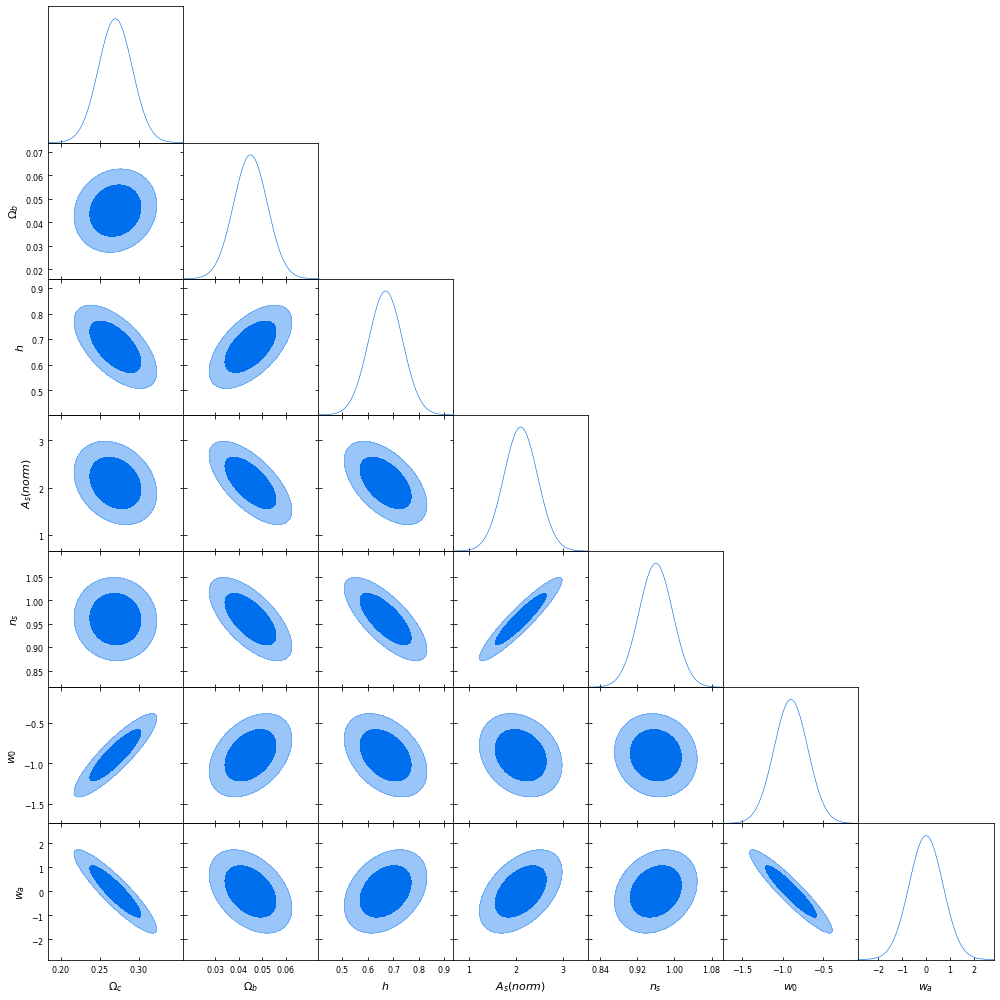

In [45]:
g.triangle_plot(gauss_no_mg_no_bias, filled = True) #reduced parameters with no mg parameters

In [46]:
#Some test cases for the degenaracy issue with wa-w0
fisher_w_test = np.delete(fisher, 0, 0)
fisher_w_test = np.delete(fisher_w_test, 0, 1)

for i in range(11):
    fisher_w_test = np.delete(fisher_w_test, 0, 0)
    fisher_w_test = np.delete(fisher_w_test, 0, 1)
    
print(np.shape(fisher_w_test))

(2, 2)


In [47]:
param_cov_w = np.linalg.inv(fisher_w_test)

In [48]:
print(param_cov_w)

[[ 0.00018503 -0.00061097]
 [-0.00061097  0.00222086]]


In [49]:
param_mean_w = [-0.9, 0.0]
param_names_w = ['w0', 'wa']
param_labels_w = [r'w_{0}', r'w_{a}']

gauss_w = GaussianND(param_mean_w, param_cov_w, labels = param_labels_w, names = param_names_w)

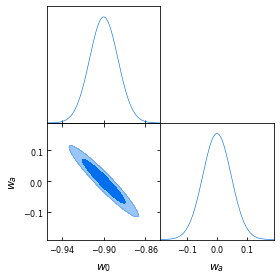

In [50]:
g.triangle_plot(gauss_w, filled = True) #test for the dark energy parameters

In [51]:
derivatives_2 = [n_s_deriv,\  #set up a derivative list that has the same structure as LSST for comparison
                 w0_deriv,\
                 wa_deriv,\
                 Omega_b_deriv,\
                 h_deriv,\
                 Omega_c_deriv,\
                 A_s_norm_deriv,\
                 bias_1_deriv,\
                 bias_2_deriv,\
                 bias_3_deriv,\
                 bias_4_deriv,\
                 bias_5_deriv,\
                 sig_0_deriv,\
                 mu_0_deriv]

In [52]:
fisher_LSST_comparison = np.zeros(shape = (14,14))

for i in range(len(derivatives_2)):
    for j in range(len(derivatives_2)):
        fisher_LSST_comparison[i][j] = np.matmul(derivatives_2[i], np.matmul(inv_cov, derivatives_2[j]))
        

In [53]:
param_cov_LSST_comparison = np.linalg.inv(fisher_LSST_comparison)

In [54]:
param_cov_LSST_cleaned = np.delete(param_cov_LSST_Y1, 0, 0)
param_cov_LSST_cleaned = np.delete(param_cov_LSST_cleaned, 0, 1)

param_cov_LSST_cleaned = np.delete(param_cov_LSST_cleaned, 0, 0)
param_cov_LSST_cleaned = np.delete(param_cov_LSST_cleaned, 0, 1)

print(np.shape(param_cov_LSST_cleaned))

(5, 5)


In [55]:
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

print(np.shape(param_cov_LSST_comparison)) #trim down parameters not in LSST forecast

(5, 5)


In [56]:
param_names_LSST_cleaned = ['n_s', 'w0', 'wa', 'omega_b', 'h0']
labels_LSST_cleaned = [r'n_{s}', r'w_{0}', r'w_{a}', r'\Omega_{b}', r'h_{0}']
mean_LSST_cleaned = [0.96, -0.9, 0.0, 0.0450, 0.67]
mean_LSST_comparison = [0.96, -0.9, 0.0, 0.045, 0.67]

gauss_LSST_cleaned = GaussianND(mean_LSST_cleaned, param_cov_LSST_cleaned, labels = labels_LSST_cleaned, names = param_names_LSST_cleaned)
gauss_LSST_comparison = GaussianND(mean_LSST_comparison, param_cov_LSST_comparison,  labels = labels_LSST_cleaned, names = param_names_LSST_cleaned )

contours = [gauss_LSST_cleaned, gauss_LSST_comparison]

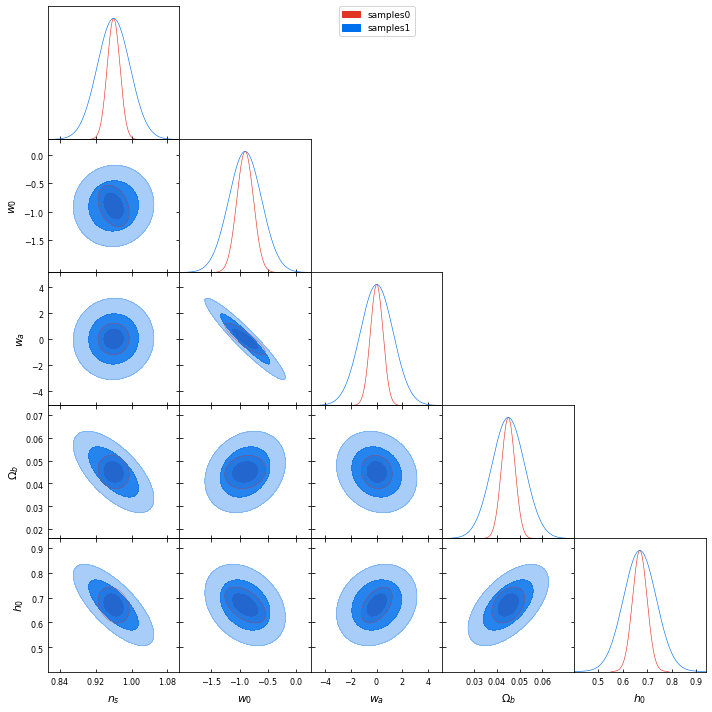

In [57]:
g.triangle_plot(contours, filled = True)

#This contour comparison is from the full parameter fisher matrix (modified gravity as well)
#at current the calculated constraint forecasts are a quite a bit larger than the constraints forecasted by the SRD analysis